# Particle filter implementation on ship tracking
### In this project, the particle filter estimation on the ship's locations in a 2D-domain is implemented, where 10000 particles and 100 paritcles are studied to compare the performance over the size of the particle filter


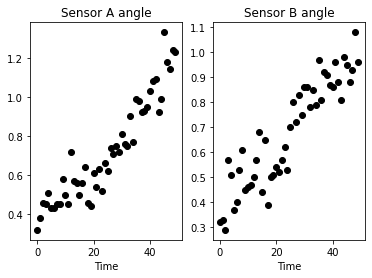

In [211]:
import numpy as np
import matplotlib.pyplot as plt
N = 50 # number of time points
yA = np.loadtxt('sensorA.txt')
yB = np.loadtxt('sensorB.txt')
y = np.vstack((yA, yB))
plt.figure()
plt.subplot(121)
plt.plot(yA, 'ko')
plt.title("Sensor A angle")
plt.xlabel("Time")
plt.subplot(122)
plt.plot(yB, 'ko')
plt.title("Sensor B angle")
plt.xlabel("Time")
plt.show()

## Set up the model

A surface vessel has state $\boldsymbol{x}_t = (\mathcal{E}_t, \mathcal{N}_t, \mathcal{v}_t, \mathcal{u}_t)$, which represents the
position along north and east, and the velocity along north and east respectively.

The initial state is $\boldsymbol{x}_t \sim \mathcal{N}_4(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)$, where

$\boldsymbol{\mu}_1 = \begin{bmatrix} 10 \\ 30 \\  10 \\  -10 \end{bmatrix}$

$\boldsymbol{\Sigma}_1 = \begin{bmatrix}10^2 & 0 & 0 & 0 \\ 0 & 10^2 & 0 & 0 \\ 0 & 0 & 5^2 & 0 \\ 0 & 0 & 0 & 5^2\end{bmatrix}$

The evolution model can be expressed as

$\boldsymbol{x}_{t + 1} = \boldsymbol{A}\boldsymbol{x}_t + \boldsymbol{\epsilon}_{t + 1}$, where
$\boldsymbol{A} = \begin{bmatrix}1 & 0 & \delta & 0 \\ 0 & 1 & 0 & \delta \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}$, and $\delta = \frac{1}{60}$

$\boldsymbol{\epsilon}_{t + 1} \sim \mathcal{N}(\boldsymbol{0}, \begin{bmatrix}0.1^2 & 0 & 0 & 0 \\ 0 & 0.1^2 & 0 & 0 \\ 0 & 0 & 0.5^2 & 0 \\ 0 & 0 & 0 & 0.5^2\end{bmatrix})$

While the observation model can be formulated as

$\boldsymbol{y}_t = \begin{bmatrix}\arctan(E_t/N_t) \\ \arctan[(40 - N_t)/(40 - E_t)]\end{bmatrix} + \boldsymbol{\epsilon}_t$, where

$\boldsymbol{\epsilon}_t \sim \mathcal{N}_2(\boldsymbol{0}, \begin{bmatrix} 0.1^2 & 0 \\ 0 & 0.1^2\end{bmatrix})$

In [212]:
A = np.eye(4)
delta = 1 / 60
A[0, 2] = delta
A[1, 3] = delta

In [213]:
mu_prior = np.vstack((10, 30, 10, -10))
Sigma_prior = np.diagflat(np.vstack((10**2, 10**2, 5**2, 5**2)))
Sigma_PP = np.diagflat(np.vstack((.1**2, .1**2, .5**2, .5**2)))
Sigma_noise = np.diagflat(np.vstack((.1**2, .1**2)))
B = 10000
L = np.linalg.cholesky(Sigma_prior)
xB = np.zeros([4, B])
xB = mu_prior * np.ones([1, B]) + np.dot(L, np.random.randn(4 * B).reshape(4, B))
mm = np.zeros([4, N])
mvar = np.zeros([4, N])
mlow = np.zeros([4, N])
mhigh = np.zeros([4, N])

In [214]:
for i in range(N):
    ya = np.arctan(np.divide(xB[0, :], xB[1, :]))
    yb = np.arctan(np.divide((40 - xB[1, :]), (40 - xB[0, :])))
    l = np.zeros([B, 1])
    for ii in range(B):
        y_est = np.vstack((ya[ii], yb[ii]))
        ydiff = y[:, i].reshape(-1, 1) - y_est
        l[ii] = np.exp(-(np.linalg.solve(Sigma_noise, ydiff).T.dot(ydiff)) / 2)

    # reweighting
    nw = l / np.sum(l) # updated weights pdf
    Fw = np.cumsum(nw) # cdf to be used for resampling

    # resampling using the weights
    xBupd = np.zeros([4, B])
    for kk in range(B):
        Ur = np.random.rand()
        ind = np.argwhere(Fw > Ur)[:, 0][0]
        xBupd[:, kk] = xB[:, ind]

    mm[:, i] = np.mean(xBupd, axis = 1)
    mvar[:, i] = np.var(xBupd, axis = 1)
    for ik in range(4):
        ms = np.sort(xBupd[ik, :])
        mlow[ik, i] = ms[int(np.ceil(.025 * B))]
        mhigh[ik, i] = ms[int(np.floor(.975 * B))]
    if i < N:
        xB = np.dot(A, xBupd) + np.dot(np.linalg.cholesky(Sigma_PP), np.random.randn(4 * B).reshape(4, B))

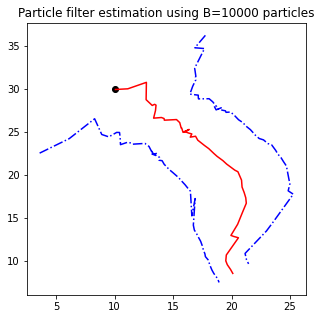

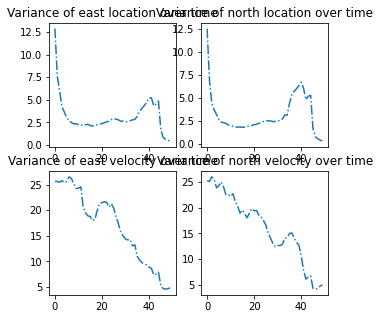

In [215]:
plt.figure(figsize = (5, 5))
plt.plot(mm[0,0], mm[1, 0], 'ko')
plt.title("Particle filter estimation using B={:d} particles".format(B))
plt.plot(mm[0, :], mm[1, :], 'r')
plt.plot(mlow[0, :], mlow[1, :], 'b-.')
plt.plot(mhigh[0, :], mhigh[1, :], 'b-.')
plt.show()

plt.figure(figsize = (5, 5))
plt.subplot(221)
plt.plot(mvar[0, :], '-.')
plt.title("Variance of east location over time")
plt.subplot(222)
plt.plot(mvar[1, :], '-.')
plt.title("Variance of north location over time")
plt.subplot(223)
plt.plot(mvar[2, :], '-.')
plt.title("Variance of east velocity over time")
plt.subplot(224)
plt.plot(mvar[3, :], '-.')
plt.title("Variance of north velocity over time")
plt.show()

One can tell that the variance increases when it encounters the singularity point where it does not know where the ship is by only using angle estimation.
The variances thus first drops at the starting point for the location estimation, and then increases and drops again.


In [216]:
B = 100
L = np.linalg.cholesky(Sigma_prior)
xB = np.zeros([4, B])
xB = mu_prior * np.ones([1, B]) + np.dot(L, np.random.randn(4 * B).reshape(4, B))
mm = np.zeros([4, N])
mvar = np.zeros([4, N])
mlow = np.zeros([4, N])
mhigh = np.zeros([4, N])
for i in range(N):
    ya = np.arctan(np.divide(xB[0, :], xB[1, :]))
    yb = np.arctan(np.divide((40 - xB[1, :]), (40 - xB[0, :])))
    l = np.zeros([B, 1])
    for ii in range(B):
        y_est = np.vstack((ya[ii], yb[ii]))
        ydiff = y[:, i].reshape(-1, 1) - y_est
        l[ii] = np.exp(-(np.linalg.solve(Sigma_noise, ydiff).T.dot(ydiff)) / 2)

    # reweighting
    nw = l / np.sum(l) # updated weights pdf
    Fw = np.cumsum(nw) # cdf to be used for resampling

    # resampling using the weights
    xBupd = np.zeros([4, B])
    for kk in range(B):
        Ur = np.random.rand()
        ind = np.argwhere(Fw > Ur)[:, 0][0]
        xBupd[:, kk] = xB[:, ind]

    mm[:, i] = np.mean(xBupd, axis = 1)
    mvar[:, i] = np.var(xBupd, axis = 1)
    for ik in range(4):
        ms = np.sort(xBupd[ik, :])
        mlow[ik, i] = ms[int(np.ceil(.025 * B))]
        mhigh[ik, i] = ms[int(np.floor(.975 * B))]
    if i < N:
        xB = np.dot(A, xBupd) + np.dot(np.linalg.cholesky(Sigma_PP), np.random.randn(4 * B).reshape(4, B))

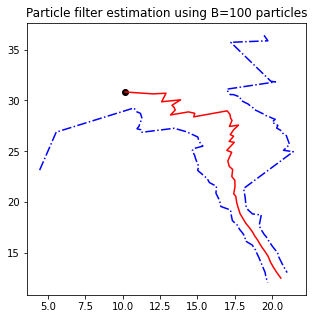

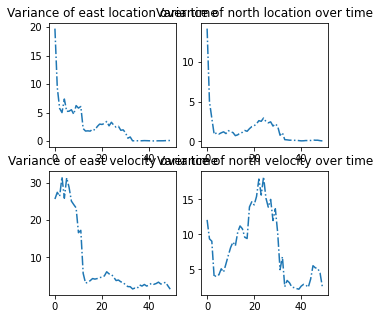

In [217]:
plt.figure(figsize = (5, 5))
plt.plot(mm[0,0], mm[1, 0], 'ko')
plt.title("Particle filter estimation using B={:d} particles".format(B))
plt.plot(mm[0, :], mm[1, :], 'r')
plt.plot(mlow[0, :], mlow[1, :], 'b-.')
plt.plot(mhigh[0, :], mhigh[1, :], 'b-.')
plt.show()

plt.figure(figsize = (5, 5))
plt.subplot(221)
plt.plot(mvar[0, :], '-.')
plt.title("Variance of east location over time")
plt.subplot(222)
plt.plot(mvar[1, :], '-.')
plt.title("Variance of north location over time")
plt.subplot(223)
plt.plot(mvar[2, :], '-.')
plt.title("Variance of east velocity over time")
plt.subplot(224)
plt.plot(mvar[3, :], '-.')
plt.title("Variance of north velocity over time")
plt.show()



When only having 100 particles, the location estimation seems still valid, whereas the variance estimation might not capture the full variation over time.

## To sum up, the particle filter provides an efficient way of estimating the location and velocities in this case, but it is important to choose the right size of the particles to both achieve the estimation accuracy and the computational efficency.

